In [42]:
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import gc
import hist
import fastjet

In [2]:
IL = 44.99
xsec = {}
xsec['qcd_300to470'] = 6833 #1300
xsec['qcd_470to600'] = 549.5
xsec['qcd_600to800'] = 156.5
xsec['qcd_800to1000'] = 26.22
xsec['qcd_1000to1400'] = 7.475
xsec['qcd_1400to1800'] = 0.6482
xsec['qcd_1800to2400'] = 0.08742
xsec['qcd_2400to3200'] = 0.005237
xsec['qcd_3200toInf'] = 0.0001353

In [3]:
#QCD sample stitching

# qcd = {}
# path = "/project01/ndcms/cmoore24/skims/jet_skims/nolepton/mc"

# for i in os.listdir(path):
#     if 'qcd' in i:
#         qcd[i] = ak.from_parquet(f'{path}/{i}', columns=['event'])

# qcd_frac = {}
# for i in qcd:
#     qcd_frac[i] = ((xsec[i]*1000)*IL)/len(qcd[i])
# qcd_frac['tot'] = sum(qcd_frac.values())
# sval = {}
# for i in qcd:
#     sval[i] = qcd_frac[i]/qcd_frac['tot']

# del(qcd)

# combed = {}
# for i in os.listdir(path):
#     if 'qcd' in i:
#         gc.collect()
#         print(i)
#         qcd_sample = ak.from_parquet(f'{path}/{i}', columns=['goodjets', 'JetCons'])
#         print('    Read')
#         ak.to_parquet(qcd_sample[np.random.rand(len(qcd_sample)) < sval[i]], f'{path}/reduced/{i}.parquet')
#         print('    Written')

In [36]:
qcd_scale = {}
path = '/project01/ndcms/cmoore24/skims/jet_skims/nolepton/mc/comparison'
for i in os.listdir(path):
    qcd_scale[i] = ak.from_parquet(f'{path}/{i}/*')


path = '/scratch365/cmoore24/training/hgg/batch2024/ml_results_checking'
with open(f'{path}/subregion_event_totals.json', 'r') as f:
    totals = json.load(f)
with open(f'{path}/my_xsecs.json', 'r') as f:
    xsecs = json.load(f)

xsecs2 = {}
for i in xsecs:
    if type(xsecs[i]) == dict:
        for j in xsecs[i]:
            xsecs2[j] = xsecs[i][j]
    else:
        xsecs2[i] = xsecs[i]
xsecs = xsecs2

totals2 = {}
for i in totals:
    if type(totals[i]) == dict:
        for j in totals[i]:
            totals2[f'{i}_{j}'] = totals[i][j]
    else:
        totals2[i] = totals[i]
totals = totals2

qcd_hist_dict = {}
for i in qcd_scale:
    qcd_hist = (hist.Hist.new
        .Reg(40, 40, 200, name='Msd', label='QCD Msd', flow=False)
        .Weight())
    qcd_hist.fill(Msd=qcd_scale[i].goodjets_msd); 
    qcd_hist_dict[i] = qcd_hist

for i in qcd_hist_dict:
    scale = ((44.99*(xsecs[i]*1000))/totals[i])
    qcd_hist_dict[i].view(flow=True)[:] *= scale

In [4]:
qcd = ak.from_parquet('/project01/ndcms/cmoore24/skims/jet_skims/nolepton/mc/reduced/*', 
                      columns=['goodjets','JetCons'])

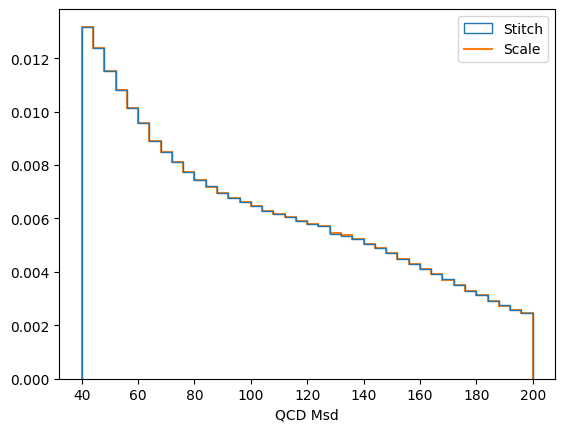

In [37]:
plt.hist(qcd.goodjets.msoftdrop, bins=40, histtype='step', density=True, label='Stitch')
sum(qcd_hist_dict[i] for i in qcd_hist_dict).plot1d(density=True, label='Scale', yerr=False)
# plt.yscale('log')
plt.legend()
plt.show()

In [45]:
jetdef = fastjet.JetDefinition(fastjet.kt_algorithm, 0.5)

In [70]:
particles = ak.flatten(qcd.JetCons, axis=1)

# Keep only the necessary fields and cast to float64
fj_ready = ak.zip({
    "px": particles.px.astype("float64"),
    "py": particles.py.astype("float64"),
    "pz": particles.pz.astype("float64"),
    "E":  particles.E.astype("float64"),
})

# Cluster
cluster = fastjet.ClusterSequence(fj_ready, jetdef)

AttributeError: no field named 'astype'